In [1]:
#pip install torchsummary

In [1]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# # For mutliple devices (GPUs: 4, 5, 6, 7)
# os.environ["CUDA_VISIBLE_DEVICES"] = "7"
from models import resnet

In [2]:
import random
import numpy as np
import torch
from torch import nn, optim
import learn2learn as l2l
from torchvision.models import resnet18
import torchvision
from torchvision import transforms
from learn2learn.data import TaskDataset
from learn2learn.data.transforms import (NWays,
                                         KShots,
                                         LoadData,
                                         RemapLabels,
                                         ConsecutiveLabels)
import torch.nn.functional as F
import random
from torchsummary import torchsummary
import higher

from jupyterplot import ProgressPlot
import numpy as np
import time
import mlogger
import utils
import argparse


Files already downloaded and verified


In [3]:
# import sys,os,argparse
# # def arg_parser():
    
# parser = argparse.ArgumentParser('MAML with Higher')

# # General
# general_params = parser.add_argument_group('General')
# general_params.add_argument('--data', type=str, default="./data",
#                             help='Path to the folder the data is downloaded to.')
# general_params.add_argument('--dataset', type=str,
#                             choices=["omniglot", "mini-imagenet", "fc100",
#                                      "cifarfs", "tiered-imagenet"], default='omniglot',
#                             help='Name of the dataset (default: omniglot).')

# meta_params = parser.add_argument_group('Meta Learning Parameters')
# meta_params.add_argument('--ways', type=int, default=5,
#                             help='Number of classes per task (N in "N-way", default: 5).')
# meta_params.add_argument('--shots', type=int, default=1,
#                             help='Number of training example per class (k in "k-shot", default: 5).')
# meta_params.add_argument('--adaptation-steps', type=int, default=1,
#                             help='Number of adaptation steps on meta-train datasets.')
# meta_params.add_argument('--num-tasks', type=int, default=32,
#                           help='Number of tasks to sample from task distribution.')
# meta_params.add_argument('--first-order', action='store_true',
#                           help='Use the first order approximation, do not use highers-order '
#                                'derivatives during meta-optimization.')
# meta_params.add_argument('--meta-lr', type=float, default=0.001,
#                           help='Learning rate for the meta-optimizer (optimization of the outer '
#                                'loss). The default optimizer is Adam (default: 1e-3).')
# meta_params.add_argument('--fast-lr', type=float, default=0.1,
#                           help='Learning rate for the meta-optimizer (optimization of the outer '
#                                'loss). The default optimizer is Adam (default: 1e-3).')
# meta_params.add_argument('--num-test-task', type=int, default=32,
#                             help='Number of test task used to calculate meta test and meta val')


# # Model
# model_params = parser.add_argument_group('Model')
# model_params.add_argument('--input', type=int, default=32,
#                           help='Input to dimension')
# model_params.add_argument('--fine-tune', type=int, default=0,
#                           help='Only meta learn the FC layer')

# # Optimization
# optim_params = parser.add_argument_group('Optimization')
# optim_params.add_argument('--num-epochs', type=int, default=50000,
#                           help='Number of epochs of meta-training (default: 50000).')
# optim_params.add_argument('--seed', type=int, default=utils.fix_seeds(),
#                           help='Number of epochs of meta-training (default: 101).')




# # Misc
# misc = parser.add_argument_group('Misc')
# misc.add_argument('--num-workers', type=int, default=4,
#                   help='Number of workers to use for data-loading (default: 1).')
# misc.add_argument('--device', type=str, default=utils.get_compute_device(), help="Compute device information")


# # Visualization
# viz = parser.add_argument_group('Misc')
# viz.add_argument('--wand_project', type=str, default="Github_Rapo",
#                   help='Wandb project name should go here')
# viz.add_argument('--username', type=str, default="hikmatkhan",
#                   help='Wandb username should go here')
# viz.add_argument('--wandb_logging', type=bool, default=True,
#                   help='If True, Logs will be reported on wandb.')
# viz.add_argument('--verbose', action='store_true')
# #     args = parser.parse_args()
# #     return parser.parse_args()
# # args = parser.parse_args()


In [4]:
# def main(argv):
#     print(argv)
    
# main(sys.argv)

In [4]:
#No randomization
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cpu')
if torch.cuda.device_count():
    torch.cuda.manual_seed(seed)
    device = torch.device('cuda')
    print("Device:", device)

Device: cuda


In [6]:
# #Dataset
# # transforms
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))])

# dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)



In [8]:
# #MetaDataset MNIST or Custom Dataset
# dataset = l2l.data.MetaDataset(dataset)
# ways = 10
# shots = 1
# transforms = [
#     NWays(dataset, n=ways),
#     KShots(dataset, k=shots),
#     LoadData(dataset),
# ]
# tasksets = TaskDataset(dataset, transforms, num_tasks=5)
# # MetaDataset Sampling
# for task in tasksets:
#     X, y = task
#     print(y)

In [9]:
#Builtin-MetaDatasets
dataset_name = "omniglot"
# "omniglot"
# "mini-imagenet", 
# "fc100", 
# "cifarfs", 
# "tiered-imagenet"

ways = 5
shots = 1
meta_batch= 8
# Create Tasksets using the benchmark interface
tasksets = l2l.vision.benchmarks.get_tasksets(dataset_name,
                                              train_samples=2*shots,
                                              train_ways=ways,
                                              test_samples=2*shots,
                                              test_ways=ways,
                                              root='~/data',
                                              num_tasks=-1)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Separate data into adaptation/evalutation sets
# adaptation_indices = np.zeros(X.size(0), dtype=bool)
# adaptation_indices[np.arange(shots*ways) * 2] = True
# evaluation_indices = torch.from_numpy(~adaptation_indices)
# adaptation_indices = torch.from_numpy(adaptation_indices)


X.size: torch.Size([10, 1, 28, 28])


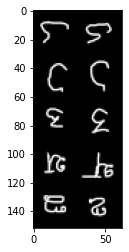

In [11]:
import matplotlib.pylab as plt
from torchvision import utils
X, y = tasksets.train.sample()
print("X.size:", X.size())
grid = utils.make_grid(X, nrow=shots * 2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [5]:
def get_indices(X, ways, shots):
    # Separate data into Meta-Train/Meta-Test sets
    meta_train_indices = np.zeros(X.size(0), dtype=bool)
    # print("X:", X.size())
    meta_train_indices[np.arange(shots * ways) * 2] = True
    meta_test_indices = torch.from_numpy(~meta_train_indices)
    meta_train_indices = torch.from_numpy(meta_train_indices)
    return meta_train_indices, meta_test_indices

def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

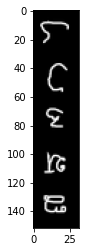

In [13]:
meta_train_indices, meta_test_indices = get_indices(X=X, ways=ways, shots=shots)
#Adaptation Data
grid = utils.make_grid(X[meta_train_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

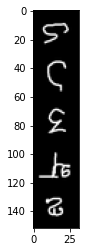

In [14]:
#Adaptation Data
grid = utils.make_grid(X[meta_test_indices], nrow=shots)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Validation: tensor([3, 3, 0, 0, 4, 4, 1, 1, 2, 2])


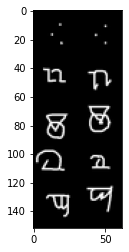

In [15]:
X, y = tasksets.validation.sample()
print("Validation:", y)
grid = utils.make_grid(X, nrow=shots*2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

Test: tensor([1, 1, 0, 0, 4, 4, 2, 2, 3, 3])


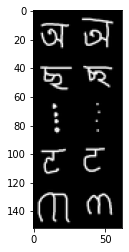

In [16]:
X, y = tasksets.test.sample()
print("Test:", y)
grid = utils.make_grid(X, nrow=shots * 2)
plt.imshow(grid.numpy().transpose((1, 2, 0)))

In [4]:
model = resnet.ResNet18S(out_dim=ways).to(device)
print(model)
# model = resnet18(pretrained=True).to(device)
# for param in model.parameters():
#     param.requires_grad = False
# num_ftrs = model.fc.in_features

# num_ftrs 
# model.fc = nn.Linear(num_ftrs, ways).to(device)

# print(model(torch.rand((1,3,84,84)).to(device)))
# torchsummary.summary(model, input_size= (3, 84, 84))

NameError: name 'ways' is not defined

In [18]:
# print(model.conv1.weight[0].grad)

In [19]:


# def main(argv):
    

In [6]:

meta_lr_lst = [0.01, 0.05, 0.09, 0.001, 0.005, 0.009]
fast_lr_lst = [0.1, 0.5, 0.9, 0.01, 0.05, 0.09, 0.001, 0.005, 0.009]
adaptation_steps_lst = [1, 5]
shots_lst = [1, 5]
meta_batch_lst = [4]

epochs = 1000
ways = 5
dataset_name = "omniglot"
model = resnet.ResNet18S(out_dim=ways).to(device)

for meta_lr in meta_lr_lst:
    for fast_lr in fast_lr_lst:
        for adaptation_steps in adaptation_steps_lst:
            for shots in shots_lst:
                for meta_batch in meta_batch_lst:

        #             meta_lr = 0.005
        #             fast_lr = 0.01
        #             adaptation_steps = 1
                    optim_meta = optim.Adam(model.parameters(), lr=meta_lr)
                    epochs = 1000
                    # pp = ProgressPlot(plot_names=["ACC", "LOSS"],
                    #                   line_names=["SS", "QS"])
                    tasksets = l2l.vision.benchmarks.get_tasksets(dataset_name,
                                              train_samples=2*shots,
                                              train_ways=ways,
                                              test_samples=2*shots,
                                              test_ways=ways,
                                              root='~/data',
                                              num_tasks=-1)



                    WANDB_LOGGER = True
                    if(WANDB_LOGGER):
                        import wandb
                        wandb.init(project="JOmniGlot", entity="hikmatkhan-", reinit=True)
                        wandb.watch(model, log_freq=10)
                        wandb.log({"Dataset":dataset_name,
                                  "Ways":ways,
                                  "Shots":shots,
                                  "Meta Batch": meta_batch,
                                  "Meta_lr": meta_lr,
                                  "Fast_lr": fast_lr,
                                  "Adaptation Step": adaptation_steps})
        #             if __name__ == "__main__":

                #     meta_train_spt_loss = mlogger.metric.Average()
                #     meta_train_spt_acc = mlogger.metric.Average()
                #     meta_train_qry_loss = mlogger.metric.Average()
                #     meta_train_qry_acc = mlogger.metric.Average()

                    for e in range(epochs):
                        optim_meta.zero_grad()
                        model.train()
                        meta_train_loss = mlogger.metric.Average()
                        meta_train_acc = mlogger.metric.Average()
                        meta_val_loss = mlogger.metric.Average()
                        meta_val_acc = mlogger.metric.Average()
                        meta_test_loss = mlogger.metric.Average()
                        meta_test_acc = mlogger.metric.Average()
                        for t in range(meta_batch):
                            X, y = tasksets.train.sample()

                            X, y = X.to(device), y.to(device)
                #             print(X.size())
                            meta_train_indices, meta_test_indices = get_indices(X=X, ways=ways, shots=shots)
                            optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
                            with higher.innerloop_ctx(model=model, opt=optim_fast, copy_initial_weights=False
                                                     ) as (fmodel, diff_opp):


                #                 print(fmodel.conv1.weight[0].grad)
                                for a in range(adaptation_steps):
                                    y_prd = fmodel(X[meta_train_indices])
                #                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                                    meta_train_spt_loss = F.cross_entropy(y_prd, y[meta_train_indices])
                #                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                                    diff_opp.step(meta_train_spt_loss)
                #                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
                #                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

                                y_prd = fmodel(X[meta_test_indices])
                                meta_train_acc.update(accuracy(y_prd, y[meta_test_indices]))
                                meta_train_qry_loss = F.cross_entropy(y_prd, y[meta_test_indices])
                                meta_train_loss.update(meta_train_qry_loss.detach().cpu().item())

                                meta_train_qry_loss.backward()


                        optim_meta.step()
                        if(WANDB_LOGGER):
                            wandb.log({"Meta Update": e})
                        print("Meta-Update")

                        for t in range(meta_batch):
                            model.eval()
                            X_val, y_val = tasksets.validation.sample()
                            X_val, y_val = X_val.to(device), y_val.to(device)

                #             print(X.size())
                            meta_train_indices, meta_test_indices = get_indices(X=X_val, ways=ways, shots=shots)
                            optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
                            with higher.innerloop_ctx(model=model, opt=optim_fast,  track_higher_grads=False
                                                     ) as (fmodel, diff_opp):


                #                 print(fmodel.conv1.weight[0].grad)
                                for a in range(adaptation_steps):
                                    y_prd = fmodel(X_val[meta_train_indices])
                #                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                                    meta_val_spt_loss = F.cross_entropy(y_prd, y_val[meta_train_indices])
                #                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                                    diff_opp.step(meta_val_spt_loss)
                #                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
                #                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

                                y_prd = fmodel(X_val[meta_test_indices])
                                meta_val_acc.update(accuracy(y_prd, y_val[meta_test_indices]))
                                meta_val_qry_loss = F.cross_entropy(y_prd, y_val[meta_test_indices])
                                meta_val_loss.update(meta_val_qry_loss.detach().cpu().item())



                        for t in range(meta_batch):
                            model.eval()
                            X_test, y_test = tasksets.test.sample()
                            X_test, y_test = X_test.to(device), y_test.to(device)

                            meta_train_indices, meta_test_indices = get_indices(X=X_test, ways=ways, shots=shots)
                            optim_fast = optim.Adam(model.parameters(), lr=fast_lr)
                            with higher.innerloop_ctx(model=model, opt=optim_fast,  track_higher_grads=False
                                                     ) as (fmodel, diff_opp):


                #                 print(fmodel.conv1.weight[0].grad)
                                for a in range(adaptation_steps):
                                    y_prd = fmodel(X_test[meta_train_indices])
                #                     a_meta_train_spt_acc.update(accuracy(y_prd, y[meta_train_indices]))
                                    meta_test_spt_loss = F.cross_entropy(y_prd, y_test[meta_train_indices])
                #                     a_meta_train_spt_loss.update(meta_train_spt_loss.detach().cpu().item())
                                    diff_opp.step(meta_test_spt_loss)
                #                 meta_train_spt_loss.update(a_meta_train_spt_loss.value)
                #                 meta_train_spt_acc.update(a_meta_train_spt_acc.value)

                                y_prd = fmodel(X_test[meta_test_indices])
                                meta_test_acc.update(accuracy(y_prd, y_test[meta_test_indices]))
                                meta_test_qry_loss = F.cross_entropy(y_prd, y_test[meta_test_indices])
                                meta_test_loss.update(meta_test_qry_loss.detach().cpu().item())


                #                 meta_train_qry_loss.backward()

                        if(WANDB_LOGGER):
                            wandb.log({
                                   "Meta Train Acc": meta_train_acc.value,
                                   "Meta Train Loss": meta_train_loss.value,
                                    "Meta Val Acc": meta_val_acc.value,
                                    "Meta Val Loss": meta_val_loss.value,
                                    "Meta Test Acc": meta_test_acc.value,
                                    "Meta Test Loss": meta_test_loss.value
                                   })
                        print("Epoch|", e, "|", "Meta Train Acc:", meta_train_acc.value, " Meta Train Loss:", meta_train_loss.value,
                             "Meta Val Acc:", meta_val_acc.value, " Meta Val Loss:", meta_val_loss.value,
                             "Meta Test Acc:", meta_test_acc.value, " Meta Test Loss:", meta_test_loss.value)


                        meta_train_loss.reset()
                        meta_train_acc.reset()
                        meta_val_loss.reset()
                        meta_val_acc.reset()
                        meta_test_loss.reset()
                        meta_test_acc.reset()

                
    

Files already downloaded and verified
Files already downloaded and verified


wandb: Currently logged in as: hikmatkhan- (use `wandb login --relogin` to force relogin)


Meta-Update
Epoch| 0 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 9.923666954040527 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.7088354612703396e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.064112517167553e+19
Meta-Update
Epoch| 1 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 14.696087121963501 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.436266073807913e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.442807607831036e+18
Meta-Update
Epoch| 2 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 11.2800572514534 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.705109153590804e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.342605667471196e+17
Meta-Update
Epoch| 3 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 7.840957283973694 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.661701324906169e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.7086214473449475e+17
Meta-Update
Epoch| 4 | Meta Train Ac

Meta-Update
Epoch| 34 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 15.516556024551392 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.915868215327326e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0055194639587082e+19
Meta-Update
Epoch| 35 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 12.475780725479126 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.699645627286159e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.744078182141395e+18
Meta-Update
Epoch| 36 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 8.919274926185608 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.240453478108365e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.767795694437925e+18
Meta-Update
Epoch| 37 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 11.961472153663635 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.315563675715633e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.309918920457585e+18
Meta-Update
Epoch| 38 | Meta T

Meta-Update
Epoch| 68 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 15.869213342666626 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.0805488534078095e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.409753164537135e+18
Meta-Update
Epoch| 69 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 11.154020309448242 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.946643471122825e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.444378984719057e+18
Meta-Update
Epoch| 70 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 10.642457962036133 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.528136600760615e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.0065101426018222e+18
Meta-Update
Epoch| 71 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 11.782948732376099 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.70672965598498e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.258930868145881e+18
Meta-Update
Epoch| 72 | Met

Meta-Update
Epoch| 102 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 10.200574159622192 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.151992703722455e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.8313807394701312e+17
Meta-Update
Epoch| 103 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 13.535854578018188 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.363209359864627e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.5089768289625702e+17
Meta-Update
Epoch| 104 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 10.408399105072021 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.191662509213614e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.170422322490245e+17
Meta-Update
Epoch| 105 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 7.9357611536979675 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.1520784585261056e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.3463179406842266e+17
Meta-Update
Epoch| 10

Meta-Update
Epoch| 136 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 8.598928213119507 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.6355066357088256e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.326345054267638e+17
Meta-Update
Epoch| 137 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 10.552253127098083 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.016778742364897e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.5451547401427354e+17
Meta-Update
Epoch| 138 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 9.049731016159058 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.3285781638702694e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.012703575801856e+17
Meta-Update
Epoch| 139 | Meta Train Acc: 0.30000000447034836  Meta Train Loss: 8.234134554862976 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.292523459608576e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.3404565558657024e+17
Meta-Update
Epoch| 140 | 

Meta-Update
Epoch| 170 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 7.63505482673645 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.142278300769452e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.674190526997332e+18
Meta-Update
Epoch| 171 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 8.18169367313385 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.8556487291350548e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1479559468870533e+18
Meta-Update
Epoch| 172 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 6.94914436340332 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.692561606847496e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.1485732296633876e+18
Meta-Update
Epoch| 173 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 7.975317716598511 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0442858731321426e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.822186182508544e+17
Meta-Update
Epoch| 174 | Met

Meta-Update
Epoch| 204 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 7.881435990333557 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.793548552916435e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.4705433212176302e+18
Meta-Update
Epoch| 205 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 7.406499266624451 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.527547255754588e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.948994350215332e+17
Meta-Update
Epoch| 206 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 8.163605451583862 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1497360132627497e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.751778965170684e+18
Meta-Update
Epoch| 207 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 5.727191925048828 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.833870441982198e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.32549069111296e+17
Meta-Update
Epoch| 208 | Met

Meta-Update
Epoch| 238 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 5.954711318016052 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1520382188126208e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0031184634236109e+18
Meta-Update
Epoch| 239 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 5.2899556159973145 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.7617846927821373e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.847274374974669e+17
Meta-Update
Epoch| 240 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 6.533539354801178 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.141328777989587e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.882026571760927e+17
Meta-Update
Epoch| 241 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 5.911645352840424 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.432502721870561e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3815102898490573e+18
Meta-Update
Epoch| 242 | 

Meta-Update
Epoch| 272 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 3.8423377275466915 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1245548304596992e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.916031647422874e+16
Meta-Update
Epoch| 273 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 6.699880957603455 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.3527537013909094e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.990201061022106e+16
Meta-Update
Epoch| 274 | Meta Train Acc: 0.30000000447034836  Meta Train Loss: 6.776072382926941 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.448474368022938e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1622030427501363e+17
Meta-Update
Epoch| 275 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 4.662630021572113 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.123165035207065e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.495734013408051e+16
Meta-Update
Epoch| 276 | M

Meta-Update
Epoch| 306 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 5.167852938175201 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.7150079290834944e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.7685877749501133e+17
Meta-Update
Epoch| 307 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 4.028251022100449 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.7598571801791693e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.638181100280873e+17
Meta-Update
Epoch| 308 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 5.869492769241333 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.6614267947266867e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.482831553363968e+17
Meta-Update
Epoch| 309 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 3.610675096511841 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.604217357897564e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.6450265909559296e+17
Meta-Update
Epoch| 310 | 

Meta-Update
Epoch| 340 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 4.200191915035248 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.285259998409523e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.9814631160754995e+17
Meta-Update
Epoch| 341 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 4.966449320316315 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.996945157430968e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.4411862950097715e+17
Meta-Update
Epoch| 342 | Meta Train Acc: 0.30000000447034836  Meta Train Loss: 5.314131855964661 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.112903089670062e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.36603682273493e+17
Meta-Update
Epoch| 343 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 6.0531275272369385 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.360254937761055e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.39819118129578e+17
Meta-Update
Epoch| 344 | Met

Meta-Update
Epoch| 374 | Meta Train Acc: 0.10000000149011612  Meta Train Loss: 5.249496340751648 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.5277658621568614e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.756222661567447e+17
Meta-Update
Epoch| 375 | Meta Train Acc: 0.2500000074505806  Meta Train Loss: 4.109460890293121 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.637405311901368e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.041340114142495e+17
Meta-Update
Epoch| 376 | Meta Train Acc: 0.10000000149011612  Meta Train Loss: 3.458124876022339 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.919786784409518e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.695071862099804e+17
Meta-Update
Epoch| 377 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 4.281236231327057 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.332070761069281e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.013685506918318e+17
Meta-Update
Epoch| 378 | Met

Meta-Update
Epoch| 408 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 3.061476171016693 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.296450671651586e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.350516372808663e+18
Meta-Update
Epoch| 409 | Meta Train Acc: 0.10000000149011613  Meta Train Loss: 4.400283396244049 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.1475192446889492e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.8124184401918034e+18
Meta-Update
Epoch| 410 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 3.3131035566329956 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.519569891865133e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.7156099804191785e+18
Meta-Update
Epoch| 411 | Meta Train Acc: 0.4000000059604645  Meta Train Loss: 2.3632051944732666 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.4891643924476068e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.7104913414750208e+18
Meta-Update
Epoch| 412 

Meta-Update
Epoch| 442 | Meta Train Acc: 0.3500000089406967  Meta Train Loss: 3.2538053691387177 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.557085286090932e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.071874721763557e+18
Meta-Update
Epoch| 443 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 5.093763113021851 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.32887221748446e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.606363610541457e+18
Meta-Update
Epoch| 444 | Meta Train Acc: 0.20000000298023227  Meta Train Loss: 4.2963650822639465 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.069767645167878e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.07128957541915e+18
Meta-Update
Epoch| 445 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 3.131694257259369 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.714558303493685e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.767413614147273e+18
Meta-Update
Epoch| 446 | Meta 

Meta-Update
Epoch| 476 | Meta Train Acc: 0.10000000149011612  Meta Train Loss: 5.124067068099976 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.2537670461457695e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.564591252376912e+18
Meta-Update
Epoch| 477 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 3.7374789118766785 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.5120775118824407e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.1494190633427927e+18
Meta-Update
Epoch| 478 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 4.30398565530777 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.422042627852468e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.3172410621432955e+18
Meta-Update
Epoch| 479 | Meta Train Acc: 0.30000000447034836  Meta Train Loss: 3.554537922143936 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.2016308160967475e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.2560244465968087e+18
Meta-Update
Epoch| 480

Meta-Update
Epoch| 510 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 2.619969993829727 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.881927314736939e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.8508558892301025e+18
Meta-Update
Epoch| 511 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 2.593573123216629 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.7632246406976635e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.5123305870487716e+18
Meta-Update
Epoch| 512 | Meta Train Acc: 0.10000000149011613  Meta Train Loss: 3.445808172225952 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.7141744649099018e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.0913932992595886e+18
Meta-Update
Epoch| 513 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 3.6287666857242584 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.9042216137971466e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.2766717631379538e+18
Meta-Update
Epoch| 514

Meta-Update
Epoch| 544 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 2.476758986711502 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1359001368959386e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.4265362444892242e+18
Meta-Update
Epoch| 545 | Meta Train Acc: 0.30000000447034836  Meta Train Loss: 2.2278976440429688 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.493642290990678e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.6409613185109197e+18
Meta-Update
Epoch| 546 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 2.3685888946056366 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.3097934327465902e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.434469770639442e+18
Meta-Update
Epoch| 547 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 2.173199415206909 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.4438184713338225e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3350309354557932e+18
Meta-Update
Epoch| 54

Meta-Update
Epoch| 578 | Meta Train Acc: 0.0  Meta Train Loss: 3.178343176841736 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.733758803144868e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.369998265997066e+17
Meta-Update
Epoch| 579 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 2.425276070833206 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.092064560028058e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.671431940038984e+17
Meta-Update
Epoch| 580 | Meta Train Acc: 0.20000000298023227  Meta Train Loss: 2.3113149404525757 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.15072747243307e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.957533643012833e+17
Meta-Update
Epoch| 581 | Meta Train Acc: 0.30000000447034836  Meta Train Loss: 2.946324408054352 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.7033595714063565e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.842580904919695e+17
Meta-Update
Epoch| 582 | Meta Train Acc: 0.

Meta-Update
Epoch| 612 | Meta Train Acc: 0.30000000447034836  Meta Train Loss: 2.399053066968918 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.359267993096028e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.710399538200576e+17
Meta-Update
Epoch| 613 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 2.9690549075603485 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.071547806032855e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.3371244459012915e+17
Meta-Update
Epoch| 614 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 2.1850202083587646 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.899275793103585e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.384207665593057e+17
Meta-Update
Epoch| 615 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 1.5970794558525085 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.14994176680919e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.067083773130834e+17
Meta-Update
Epoch| 616 | 

Meta-Update
Epoch| 646 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 1.473632663488388 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.038973485569802e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.545138989175931e+17
Meta-Update
Epoch| 647 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 2.0792378783226013 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.0262634747500954e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.0340585826942976e+17
Meta-Update
Epoch| 648 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 1.5734432935714722 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.91070830885077e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.404492382328586e+17
Meta-Update
Epoch| 649 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 1.8087811172008514 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.168933784287969e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.1476518777389056e+17
Meta-Update
Epoch| 650 |

Meta-Update
Epoch| 680 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 1.87760791182518 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.407651502573486e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.817901382721864e+17
Meta-Update
Epoch| 681 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 1.8995056450366974 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.267332773529518e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.631244579425485e+17
Meta-Update
Epoch| 682 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 1.765269249677658 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.506891946114417e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.986508882474435e+17
Meta-Update
Epoch| 683 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 2.338105231523514 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.365585647983657e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.141261122507899e+17
Meta-Update
Epoch| 684 | Meta T

Meta-Update
Epoch| 714 | Meta Train Acc: 0.10000000149011612  Meta Train Loss: 2.457712858915329 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.003907591805338e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.340764628088259e+17
Meta-Update
Epoch| 715 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 2.067988008260727 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.822789545295872e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1839451872572211e+17
Meta-Update
Epoch| 716 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 1.6888178288936615 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.649383219940557e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3171704556892981e+17
Meta-Update
Epoch| 717 | Meta Train Acc: 0.4000000059604645  Meta Train Loss: 1.5625180006027222 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.77815565542359e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1951849233973248e+17
Meta-Update
Epoch| 718 | 

Meta-Update
Epoch| 748 | Meta Train Acc: 0.30000000447034836  Meta Train Loss: 1.751345455646515 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.234131070674534e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.584152034698854e+16
Meta-Update
Epoch| 749 | Meta Train Acc: 0.30000000447034836  Meta Train Loss: 1.7477955222129822 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.305212552698921e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.811627408477389e+16
Meta-Update
Epoch| 750 | Meta Train Acc: 0.30000000447034836  Meta Train Loss: 1.8080022633075714 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.6356273556763443e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.32297915447378e+16
Meta-Update
Epoch| 751 | Meta Train Acc: 0.10000000149011612  Meta Train Loss: 1.9309284090995789 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.540458285911245e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0947572063535104e+17
Meta-Update
Epoch| 752 |

Meta-Update
Epoch| 782 | Meta Train Acc: 0.10000000149011612  Meta Train Loss: 2.0004478693008423 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.4050828800373555e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.3693714510367952e+17
Meta-Update
Epoch| 783 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 1.9098750948905945 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.4757466884682547e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.453970227172475e+17
Meta-Update
Epoch| 784 | Meta Train Acc: 0.30000000819563866  Meta Train Loss: 1.5498080849647522 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.4559836483721626e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.6823564767893917e+17
Meta-Update
Epoch| 785 | Meta Train Acc: 0.10000000149011612  Meta Train Loss: 1.9942261278629303 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.366905179222835e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.4612299195377254e+17
Meta-Update
Epoch|

Meta-Update
Epoch| 816 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 1.7321107983589172 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.7150761546389914e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.7644751736170086e+17
Meta-Update
Epoch| 817 | Meta Train Acc: 0.20000000298023227  Meta Train Loss: 2.082262396812439 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.967925937504256e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.5625022840242176e+17
Meta-Update
Epoch| 818 | Meta Train Acc: 0.2500000037252903  Meta Train Loss: 1.775640219449997 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.280254606354678e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.498302349338215e+17
Meta-Update
Epoch| 819 | Meta Train Acc: 0.05000000074505807  Meta Train Loss: 2.025969296693802 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.5142455941935923e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.086481493220393e+17
Meta-Update
Epoch| 820 | 

Meta-Update
Epoch| 850 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 1.8341717422008514 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.3545457764951654e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1380017502932173e+17
Meta-Update
Epoch| 851 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 1.7900280058383942 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.066665009689395e+16 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.462690552015749e+17
Meta-Update
Epoch| 852 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 1.7076457142829895 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.3686921961773466e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.24721467426865e+17
Meta-Update
Epoch| 853 | Meta Train Acc: 0.45000000670552254  Meta Train Loss: 1.4871017634868622 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.640926529275822e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2744781586445107e+17
Meta-Update
Epoch| 85

Meta-Update
Epoch| 884 | Meta Train Acc: 0.20000000298023227  Meta Train Loss: 1.583655834197998 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.626683386930135e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.1412778125859226e+17
Meta-Update
Epoch| 885 | Meta Train Acc: 0.05000000074505807  Meta Train Loss: 2.5703847408294678 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.7178942602621747e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.00652121651413e+17
Meta-Update
Epoch| 886 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 1.7546228468418121 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.0256055972646093e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.261276573124526e+17
Meta-Update
Epoch| 887 | Meta Train Acc: 0.20000000298023227  Meta Train Loss: 1.7089558243751526 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.903090973733028e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.557162367704105e+17
Meta-Update
Epoch| 888 

Meta-Update
Epoch| 918 | Meta Train Acc: 0.2500000074505806  Meta Train Loss: 1.7998973727226257 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.043890739114148e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.7426836089038442e+17
Meta-Update
Epoch| 919 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 2.0238316655158997 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.8076289954584986e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.317174455790469e+17
Meta-Update
Epoch| 920 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 1.7789236307144165 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.5872161007101542e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.2685247169835827e+17
Meta-Update
Epoch| 921 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 1.780547857284546 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.2742817555716506e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2664218307893658e+17
Meta-Update
Epoch| 9

Meta-Update
Epoch| 952 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 2.339741826057434 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.810728380967158e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.500739272483799e+17
Meta-Update
Epoch| 953 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 2.1694160401821136 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.85150637805011e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.825582970550354e+17
Meta-Update
Epoch| 954 | Meta Train Acc: 0.05000000074505806  Meta Train Loss: 2.8018073439598083 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.04301345652736e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.440441914404372e+17
Meta-Update
Epoch| 955 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 2.416023463010788 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.259463089259807e+17 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.146643630036091e+17
Meta-Update
Epoch| 956 | Met

Meta-Update
Epoch| 986 | Meta Train Acc: 0.30000000819563866  Meta Train Loss: 2.584421455860138 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.9716888155085865e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.5825365691457864e+18
Meta-Update
Epoch| 987 | Meta Train Acc: 0.20000000298023224  Meta Train Loss: 2.021160215139389 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.0130368092645622e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.873776858378535e+18
Meta-Update
Epoch| 988 | Meta Train Acc: 0.15000000223517418  Meta Train Loss: 1.9374076128005981 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.709159558015877e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.8539557217464484e+18
Meta-Update
Epoch| 989 | Meta Train Acc: 0.3500000089406967  Meta Train Loss: 2.6028913855552673 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.8028412128775373e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.8708807791107113e+18
Meta-Update
Epoch| 99

Dataset,omniglot
Ways,5
Shots,1
Meta Batch,4
Meta_lr,0.01
Fast_lr,0.1
Adaptation Step,1
_runtime,3562
_timestamp,1629340145
_step,2000
Meta Update,999


Ways,▁
Shots,▁
Meta Batch,▁
Meta_lr,▁
Fast_lr,▁
Adaptation Step,▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Update,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Train Acc,▃▃█▃▃▁▃▃▃▆▆▃▃▁▆▁▆▁▃▆▆▁▃▆▃█▁█▆▃▆▁▆▁▃▁▁▁▃▆


Meta-Update
Epoch| 0 | Meta Train Acc: 0.20999999716877937  Meta Train Loss: 2.4245025515556335 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.922463720239268e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 6.38365304787619e+18
Meta-Update
Epoch| 1 | Meta Train Acc: 0.2499999925494194  Meta Train Loss: 1.7549132406711578 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.25942752247074e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.3475890978716385e+18
Meta-Update
Epoch| 2 | Meta Train Acc: 0.20999999158084393  Meta Train Loss: 1.6563304364681244 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.9749352796950364e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.698386767911846e+18
Meta-Update
Epoch| 3 | Meta Train Acc: 0.17999999225139618  Meta Train Loss: 1.611735850572586 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.7881283385486213e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.5290864501893628e+19
Meta-Update
Epoch| 4 | Meta Trai

Meta-Update
Epoch| 34 | Meta Train Acc: 0.28999999165534973  Meta Train Loss: 1.5997729301452637 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.4131265319573914e+17 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.6127860968259584e+17
Meta-Update
Epoch| 35 | Meta Train Acc: 0.32999999076128006  Meta Train Loss: 1.595231682062149 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.6335567089932698e+17 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.6803492824665293e+17
Meta-Update
Epoch| 36 | Meta Train Acc: 0.1699999962002039  Meta Train Loss: 1.6648604273796082 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.746628036662395e+17 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.426080582818857e+17
Meta-Update
Epoch| 37 | Meta Train Acc: 0.1599999964237213  Meta Train Loss: 1.7150260508060455 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.6477895541548646e+17 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.4251135065076531e+17
Meta-Update
Epoch| 38 | M

Meta-Update
Epoch| 68 | Meta Train Acc: 0.139999995008111  Meta Train Loss: 2.786600708961487 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.1491775355728744e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0308171099539505e+20
Meta-Update
Epoch| 69 | Meta Train Acc: 0.20999999716877937  Meta Train Loss: 1.785416692495346 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.243524029606181e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.5828404667127903e+20
Meta-Update
Epoch| 70 | Meta Train Acc: 0.23999999463558197  Meta Train Loss: 1.9052970707416534 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.8685096028456972e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.7188606216250925e+21
Meta-Update
Epoch| 71 | Meta Train Acc: 0.29999998956918716  Meta Train Loss: 1.836788535118103 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.152556156054205e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.180044734427193e+21
Meta-Update
Epoch| 72 | Meta

Meta-Update
Epoch| 102 | Meta Train Acc: 0.35999999195337296  Meta Train Loss: 1.3850117623806 Meta Val Acc: 0.15999999083578587  Meta Val Loss: 2.17330697600204e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.705488879678233e+20
Meta-Update
Epoch| 103 | Meta Train Acc: 0.3199999965727329  Meta Train Loss: 1.466269850730896 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.329855395634967e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.2767527223529203e+20
Meta-Update
Epoch| 104 | Meta Train Acc: 0.4399999901652336  Meta Train Loss: 1.323313057422638 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.449721338545339e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.586405193361203e+20
Meta-Update
Epoch| 105 | Meta Train Acc: 0.3799999952316284  Meta Train Loss: 1.3601984977722168 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.9802688841575406e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.115545538062356e+20
Meta-Update
Epoch| 106 | Meta T

Meta-Update
Epoch| 136 | Meta Train Acc: 0.4399999901652336  Meta Train Loss: 1.301397830247879 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.011492283698832e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.4545404300898284e+20
Meta-Update
Epoch| 137 | Meta Train Acc: 0.4099999889731407  Meta Train Loss: 1.420432448387146 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.582328794082978e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.130275143634502e+20
Meta-Update
Epoch| 138 | Meta Train Acc: 0.28999999165534973  Meta Train Loss: 1.4613187611103058 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.5036965163351356e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.815275241804996e+20
Meta-Update
Epoch| 139 | Meta Train Acc: 0.3399999886751175  Meta Train Loss: 1.4113257229328156 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.877565941973443e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.388874760888401e+20
Meta-Update
Epoch| 140 | Me

Meta-Update
Epoch| 170 | Meta Train Acc: 0.22999999672174454  Meta Train Loss: 1.9916880428791046 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.5222722210281554e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.840729530523714e+18
Meta-Update
Epoch| 171 | Meta Train Acc: 0.31999998912215233  Meta Train Loss: 1.6670276522636414 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0389338559730418e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.6910148261468176e+19
Meta-Update
Epoch| 172 | Meta Train Acc: 0.31999998912215233  Meta Train Loss: 1.6042888164520264 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.456100634691371e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.1079907315959202e+19
Meta-Update
Epoch| 173 | Meta Train Acc: 0.22999999672174454  Meta Train Loss: 1.7346685528755188 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.189016409762431e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.731025859917696e+19
Meta-Update
Epoch| 1

Meta-Update
Epoch| 204 | Meta Train Acc: 0.24999999068677425  Meta Train Loss: 1.7327688038349152 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.2168098333028516e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.787649676006654e+18
Meta-Update
Epoch| 205 | Meta Train Acc: 0.3299999963492155  Meta Train Loss: 1.495664358139038 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.6900731229493e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.9943351659347313e+18
Meta-Update
Epoch| 206 | Meta Train Acc: 0.3399999886751175  Meta Train Loss: 1.5380640625953674 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.255075639754752e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.410041355356078e+18
Meta-Update
Epoch| 207 | Meta Train Acc: 0.2699999902397394  Meta Train Loss: 1.5724996328353882 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.948827600918414e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.8644579161908183e+18
Meta-Update
Epoch| 208 | Me

Meta-Update
Epoch| 238 | Meta Train Acc: 0.22999999672174454  Meta Train Loss: 1.7552648186683655 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.880283163460318e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.920344996617755e+19
Meta-Update
Epoch| 239 | Meta Train Acc: 0.26999999396502966  Meta Train Loss: 1.6422972083091736 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.7579965247551177e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2775468595199082e+19
Meta-Update
Epoch| 240 | Meta Train Acc: 0.279999990016222  Meta Train Loss: 1.8084497451782227 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.252984993060487e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.7445296788503265e+19
Meta-Update
Epoch| 241 | Meta Train Acc: 0.20999999344348907  Meta Train Loss: 1.6848272681236267 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.6065404178592694e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.040181703513945e+19
Meta-Update
Epoch| 242

Meta-Update
Epoch| 272 | Meta Train Acc: 0.29999998956918716  Meta Train Loss: 1.4981319904327393 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.5195121778125963e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.107211191694131e+18
Meta-Update
Epoch| 273 | Meta Train Acc: 0.3199999928474426  Meta Train Loss: 1.4117217063903809 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.618071125941289e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2559647656806187e+19
Meta-Update
Epoch| 274 | Meta Train Acc: 0.26999999582767487  Meta Train Loss: 1.5206663012504578 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.857748014989836e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.896730306399437e+18
Meta-Update
Epoch| 275 | Meta Train Acc: 0.2499999888241291  Meta Train Loss: 1.5658464431762695 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.09274501731346e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0600185170080301e+19
Meta-Update
Epoch| 276 |

Meta-Update
Epoch| 306 | Meta Train Acc: 0.1999999973922968  Meta Train Loss: 1.7945171296596527 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.411620889216222e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.92597551084083e+22
Meta-Update
Epoch| 307 | Meta Train Acc: 0.25999999418854713  Meta Train Loss: 1.6254892349243164 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.9741666104563512e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2003980240366221e+23
Meta-Update
Epoch| 308 | Meta Train Acc: 0.3399999924004078  Meta Train Loss: 1.4994604289531708 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.984697626513527e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.023620424718782e+22
Meta-Update
Epoch| 309 | Meta Train Acc: 0.24999999813735485  Meta Train Loss: 1.5226337611675262 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.6390048998159e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.649772533984611e+22
Meta-Update
Epoch| 310 | Me

Meta-Update
Epoch| 340 | Meta Train Acc: 0.439999982714653  Meta Train Loss: 1.3858949840068817 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.305870070893213e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.978101678819141e+21
Meta-Update
Epoch| 341 | Meta Train Acc: 0.35999998450279236  Meta Train Loss: 1.4406648874282837 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.293754141299068e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.3660830371327907e+21
Meta-Update
Epoch| 342 | Meta Train Acc: 0.4099999889731407  Meta Train Loss: 1.3767685294151306 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.5513654182962077e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.346669778357801e+21
Meta-Update
Epoch| 343 | Meta Train Acc: 0.3799999877810478  Meta Train Loss: 1.3438388407230377 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.8064646415767034e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.4721501467476377e+21
Meta-Update
Epoch| 344 |

Meta-Update
Epoch| 374 | Meta Train Acc: 0.439999982714653  Meta Train Loss: 1.3566724359989166 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0078447804183615e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.258334393558383e+21
Meta-Update
Epoch| 375 | Meta Train Acc: 0.4099999889731407  Meta Train Loss: 1.3495844304561615 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0331344978352559e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.280622267858241e+20
Meta-Update
Epoch| 376 | Meta Train Acc: 0.3799999803304672  Meta Train Loss: 1.416118562221527 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0726990427741707e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.3945216805855088e+21
Meta-Update
Epoch| 377 | Meta Train Acc: 0.31999998912215233  Meta Train Loss: 1.419568121433258 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 9.053960868543794e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.10488799334522e+21
Meta-Update
Epoch| 378 | Me

Meta-Update
Epoch| 408 | Meta Train Acc: 0.4099999815225601  Meta Train Loss: 1.169776290655136 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.1114753698173654e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0314145098056933e+21
Meta-Update
Epoch| 409 | Meta Train Acc: 0.44999998807907104  Meta Train Loss: 1.2726242542266846 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2630898956977234e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.323725762494967e+20
Meta-Update
Epoch| 410 | Meta Train Acc: 0.41999998688697815  Meta Train Loss: 1.2103643119335175 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.0749679246005051e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.54183869884666e+20
Meta-Update
Epoch| 411 | Meta Train Acc: 0.3799999915063381  Meta Train Loss: 1.3491231501102448 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.435440102118869e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.092891177994091e+21
Meta-Update
Epoch| 412 |

Meta-Update
Epoch| 442 | Meta Train Acc: 0.4599999934434891  Meta Train Loss: 1.2180898487567902 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.493606785810862e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.8953750196309092e+20
Meta-Update
Epoch| 443 | Meta Train Acc: 0.4399999901652336  Meta Train Loss: 1.1989217400550842 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.072248617340072e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.5008811107597628e+20
Meta-Update
Epoch| 444 | Meta Train Acc: 0.4299999848008156  Meta Train Loss: 1.1668368577957153 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.5451204908182667e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.4011707333125708e+20
Meta-Update
Epoch| 445 | Meta Train Acc: 0.41999998688697815  Meta Train Loss: 1.2143492102622986 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.013249219217798e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.9365612318209396e+20
Meta-Update
Epoch| 446

Meta-Update
Epoch| 476 | Meta Train Acc: 0.5999999865889549  Meta Train Loss: 1.117743819952011 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.840480968277649e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.0028683922890555e+19
Meta-Update
Epoch| 477 | Meta Train Acc: 0.38999998569488525  Meta Train Loss: 1.3586034774780273 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.2768051172796785e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.166257143489233e+19
Meta-Update
Epoch| 478 | Meta Train Acc: 0.4599999934434891  Meta Train Loss: 1.2521504163742065 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.413325538737835e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.4350189914652934e+19
Meta-Update
Epoch| 479 | Meta Train Acc: 0.4399999901652336  Meta Train Loss: 1.2335388958454132 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.965609901465587e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 8.821649300825886e+19
Meta-Update
Epoch| 480 | 

Meta-Update
Epoch| 510 | Meta Train Acc: 0.23999999277293685  Meta Train Loss: 1.4167220294475555 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.7521774949547114e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.3115031007095947e+19
Meta-Update
Epoch| 511 | Meta Train Acc: 0.439999982714653  Meta Train Loss: 1.1780997812747955 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.688141415485014e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.532352789072367e+19
Meta-Update
Epoch| 512 | Meta Train Acc: 0.4599999859929085  Meta Train Loss: 1.2165009379386902 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.5767036305232888e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.4132337117759013e+19
Meta-Update
Epoch| 513 | Meta Train Acc: 0.48999999463558197  Meta Train Loss: 1.2164268791675568 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.5865675986755387e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.1367559879256965e+19
Meta-Update
Epoch| 51

Meta-Update
Epoch| 544 | Meta Train Acc: 0.5399999842047691  Meta Train Loss: 1.1904118061065674 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.524901510671446e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.905925722354483e+19
Meta-Update
Epoch| 545 | Meta Train Acc: 0.4699999913573265  Meta Train Loss: 1.2082152664661407 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.122768711780978e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.729901055623771e+19
Meta-Update
Epoch| 546 | Meta Train Acc: 0.4899999871850014  Meta Train Loss: 1.243675410747528 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.2273107721301524e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.926947033877106e+19
Meta-Update
Epoch| 547 | Meta Train Acc: 0.4699999839067459  Meta Train Loss: 1.2620306313037872 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.0387141559072063e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.530101075620764e+19
Meta-Update
Epoch| 548 | Me

Meta-Update
Epoch| 578 | Meta Train Acc: 0.4999999850988388  Meta Train Loss: 1.143540471792221 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.4286209097141846e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.3872479383777706e+19
Meta-Update
Epoch| 579 | Meta Train Acc: 0.35999998822808266  Meta Train Loss: 1.4253278374671936 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.7348676242139775e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.675334393379999e+19
Meta-Update
Epoch| 580 | Meta Train Acc: 0.5099999904632568  Meta Train Loss: 1.1524692177772522 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.1559909523438174e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.863177260022366e+19
Meta-Update
Epoch| 581 | Meta Train Acc: 0.3999999985098839  Meta Train Loss: 1.2527117729187012 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.6674789080408e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.538879356554602e+19
Meta-Update
Epoch| 582 | M

Meta-Update
Epoch| 612 | Meta Train Acc: 0.5399999767541885  Meta Train Loss: 1.1139197498559952 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3633798169278231e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.292658785325909e+20
Meta-Update
Epoch| 613 | Meta Train Acc: 0.5299999862909317  Meta Train Loss: 1.1027640402317047 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.036749215129005e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.0139105534716726e+20
Meta-Update
Epoch| 614 | Meta Train Acc: 0.5599999874830246  Meta Train Loss: 1.062264621257782 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.2942543105885628e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.8762820642359214e+20
Meta-Update
Epoch| 615 | Meta Train Acc: 0.5699999928474426  Meta Train Loss: 1.15978142619133 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2200851394041951e+20 Meta Test Acc: 0.20999998971819878  Meta Test Loss: 2.045663032861199e+20
Meta-Update
Epoch| 616 | M

Meta-Update
Epoch| 646 | Meta Train Acc: 0.4099999815225601  Meta Train Loss: 1.3690723776817322 Meta Val Acc: 0.20999998971819878  Meta Val Loss: 6.651688831399494e+18 Meta Test Acc: 0.22999998927116394  Meta Test Loss: 1.1467826837988573e+19
Meta-Update
Epoch| 647 | Meta Train Acc: 0.5799999833106995  Meta Train Loss: 1.1075059473514557 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.9566101076599374e+19 Meta Test Acc: 0.1899999901652336  Meta Test Loss: 7.770360548801118e+18
Meta-Update
Epoch| 648 | Meta Train Acc: 0.48999999463558197  Meta Train Loss: 1.2677981704473495 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.859009865512334e+19 Meta Test Acc: 0.17999999038875103  Meta Test Loss: 6.801351296155648e+18
Meta-Update
Epoch| 649 | Meta Train Acc: 0.41999998688697815  Meta Train Loss: 1.3962469696998596 Meta Val Acc: 0.17999999038875103  Meta Val Loss: 1.3928622268558082e+19 Meta Test Acc: 0.2799999862909317  Meta Test Loss: 2.7787287938000224e+19
Meta-Update
Epoch| 650 |

Meta-Update
Epoch| 680 | Meta Train Acc: 0.5699999891221523  Meta Train Loss: 1.1316882967948914 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 7.002590542264743e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.8203239722010123e+20
Meta-Update
Epoch| 681 | Meta Train Acc: 0.559999980032444  Meta Train Loss: 1.1219867020845413 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3572594844078545e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.6036309278733317e+20
Meta-Update
Epoch| 682 | Meta Train Acc: 0.5299999788403511  Meta Train Loss: 1.2549552023410797 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.4392492014251278e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.1556038611480609e+20
Meta-Update
Epoch| 683 | Meta Train Acc: 0.4999999925494194  Meta Train Loss: 1.1086867451667786 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.791824969357801e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.817539351899695e+19
Meta-Update
Epoch| 684 |

Meta-Update
Epoch| 714 | Meta Train Acc: 0.5999999791383743  Meta Train Loss: 0.9042715728282928 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.208192329480667e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.94118963551965e+19
Meta-Update
Epoch| 715 | Meta Train Acc: 0.5099999830126762  Meta Train Loss: 1.0377241373062134 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.3048722501661626e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.635758757392417e+19
Meta-Update
Epoch| 716 | Meta Train Acc: 0.5299999788403511  Meta Train Loss: 1.0795444697141647 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 5.6676414001661346e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.315292463530037e+19
Meta-Update
Epoch| 717 | Meta Train Acc: 0.4099999889731407  Meta Train Loss: 1.2688159495592117 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.2521036087480025e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.990897323952046e+19
Meta-Update
Epoch| 718 | M

Meta-Update
Epoch| 748 | Meta Train Acc: 0.4899999871850014  Meta Train Loss: 1.1798472553491592 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.986317072208232e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.307324135326299e+19
Meta-Update
Epoch| 749 | Meta Train Acc: 0.5499999821186066  Meta Train Loss: 0.9703521281480789 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.1008905535956084e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.625824846094008e+19
Meta-Update
Epoch| 750 | Meta Train Acc: 0.5899999737739563  Meta Train Loss: 0.8679458051919937 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.479747576247301e+19 Meta Test Acc: 0.1899999901652336  Meta Test Loss: 6.04357396396612e+19
Meta-Update
Epoch| 751 | Meta Train Acc: 0.6099999845027924  Meta Train Loss: 1.0222939103841782 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 8.36246875859908e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.6694699873096804e+20
Meta-Update
Epoch| 752 | Meta

Meta-Update
Epoch| 782 | Meta Train Acc: 0.5199999809265137  Meta Train Loss: 1.130611389875412 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.068516534145935e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.4776339730857984e+18
Meta-Update
Epoch| 783 | Meta Train Acc: 0.609999991953373  Meta Train Loss: 0.9695738106966019 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.3166605700568187e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.186837182176035e+18
Meta-Update
Epoch| 784 | Meta Train Acc: 0.6199999749660492  Meta Train Loss: 0.91605444252491 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.9931402862761345e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.4458081407034982e+18
Meta-Update
Epoch| 785 | Meta Train Acc: 0.5299999862909317  Meta Train Loss: 1.1883812844753265 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.1944588634709033e+18 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 9.895033591132324e+17
Meta-Update
Epoch| 786 | Me

Meta-Update
Epoch| 816 | Meta Train Acc: 0.439999982714653  Meta Train Loss: 1.1163030862808228 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.852233701794188e+22 Meta Test Acc: 0.22999998927116394  Meta Test Loss: 3.5652580960384416e+22
Meta-Update
Epoch| 817 | Meta Train Acc: 0.6599999815225601  Meta Train Loss: 0.8062005937099457 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.306581585478834e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.1560993570939103e+23
Meta-Update
Epoch| 818 | Meta Train Acc: 0.5599999949336052  Meta Train Loss: 0.9809439033269882 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.234362293861551e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.3597255951204288e+23
Meta-Update
Epoch| 819 | Meta Train Acc: 0.5099999904632568  Meta Train Loss: 1.1119138449430466 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 6.685402750502296e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0841616545075625e+23
Meta-Update
Epoch| 820 | 

Meta-Update
Epoch| 850 | Meta Train Acc: 0.5799999758601189  Meta Train Loss: 0.9201412200927734 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 4.450806462213622e+21 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.526371523282415e+21
Meta-Update
Epoch| 851 | Meta Train Acc: 0.5499999895691872  Meta Train Loss: 1.1240220367908478 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.482844306152662e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.8575671153517077e+22
Meta-Update
Epoch| 852 | Meta Train Acc: 0.5999999865889549  Meta Train Loss: 0.8981253802776337 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.23111159396237e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.2229843558535707e+22
Meta-Update
Epoch| 853 | Meta Train Acc: 0.5799999833106995  Meta Train Loss: 0.9403336495161057 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.6918373571913784e+22 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.262992306183806e+22
Meta-Update
Epoch| 854 | M

Meta-Update
Epoch| 884 | Meta Train Acc: 0.6099999994039536  Meta Train Loss: 1.0620914846658707 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.6388872602494226e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0408647220864745e+20
Meta-Update
Epoch| 885 | Meta Train Acc: 0.5799999833106995  Meta Train Loss: 1.0587465465068817 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.5524822049513433e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.02680119870908e+20
Meta-Update
Epoch| 886 | Meta Train Acc: 0.5799999758601189  Meta Train Loss: 0.9971389770507812 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 2.3326290695970148e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.5424380562804467e+20
Meta-Update
Epoch| 887 | Meta Train Acc: 0.5499999821186066  Meta Train Loss: 1.1474080681800842 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.5312282108793402e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 1.0738480588134757e+20
Meta-Update
Epoch| 888

Meta-Update
Epoch| 918 | Meta Train Acc: 0.5899999737739563  Meta Train Loss: 0.8743100315332413 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.5609570866466128e+19 Meta Test Acc: 0.16999999061226845  Meta Test Loss: 4.053131912493924e+19
Meta-Update
Epoch| 919 | Meta Train Acc: 0.5599999986588955  Meta Train Loss: 1.1500882506370544 Meta Val Acc: 0.17999999038875103  Meta Val Loss: 4.984829533544566e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 5.5097731633087775e+19
Meta-Update
Epoch| 920 | Meta Train Acc: 0.5499999821186066  Meta Train Loss: 1.0918970704078674 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.7848586246138364e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 4.271655670370219e+19
Meta-Update
Epoch| 921 | Meta Train Acc: 0.7199999839067459  Meta Train Loss: 0.6822791695594788 Meta Val Acc: 0.20999998971819878  Meta Val Loss: 3.43297805244338e+19 Meta Test Acc: 0.20999998971819878  Meta Test Loss: 4.987708439815153e+19
Meta-Update
Epoch| 922 | M

Meta-Update
Epoch| 952 | Meta Train Acc: 0.6199999749660492  Meta Train Loss: 0.900715172290802 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.5160161926311523e+20 Meta Test Acc: 0.16999999061226845  Meta Test Loss: 6.739040577204204e+19
Meta-Update
Epoch| 953 | Meta Train Acc: 0.6899999976158142  Meta Train Loss: 0.7784162685275078 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.20042199731992e+19 Meta Test Acc: 0.1899999901652336  Meta Test Loss: 8.835658068524217e+19
Meta-Update
Epoch| 954 | Meta Train Acc: 0.6899999678134918  Meta Train Loss: 0.8513582050800323 Meta Val Acc: 0.19999999180436134  Meta Val Loss: 2.757411280254088e+19 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 7.896459029393074e+19
Meta-Update
Epoch| 955 | Meta Train Acc: 0.5699999779462814  Meta Train Loss: 1.0293798297643661 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.507475297856599e+19 Meta Test Acc: 0.19999999180436134  Meta Test Loss: 3.484621921185484e+19
Meta-Update
Epoch| 956 | Meta 

Meta-Update
Epoch| 986 | Meta Train Acc: 0.679999977350235  Meta Train Loss: 1.03046116232872 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 1.2442909978408464e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.1570227689900265e+20
Meta-Update
Epoch| 987 | Meta Train Acc: 0.7399999797344208  Meta Train Loss: 0.7520313560962677 Meta Val Acc: 0.1899999901652336  Meta Val Loss: 1.913279314995341e+20 Meta Test Acc: 0.20999998971819878  Meta Test Loss: 1.4227663970747023e+20
Meta-Update
Epoch| 988 | Meta Train Acc: 0.689999982714653  Meta Train Loss: 0.9048040956258774 Meta Val Acc: 0.2199999913573265  Meta Val Loss: 6.494853448277479e+20 Meta Test Acc: 0.1899999901652336  Meta Test Loss: 1.7354677788921037e+20
Meta-Update
Epoch| 989 | Meta Train Acc: 0.5199999883770943  Meta Train Loss: 0.9358396381139755 Meta Val Acc: 0.1899999901652336  Meta Val Loss: 3.474253993827998e+20 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 2.688577839137869e+20
Meta-Update
Epoch| 990 | Meta Tr

Dataset,omniglot
Ways,5
Shots,5
Meta Batch,4
Meta_lr,0.01
Fast_lr,0.1
Adaptation Step,1
_runtime,6627
_timestamp,1629346783
_step,2000
Meta Update,999


Ways,▁
Shots,▁
Meta Batch,▁
Meta_lr,▁
Fast_lr,▁
Adaptation Step,▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Update,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Train Acc,▂▃▂▃▃▄▃▃▃▅▁▃▄▃▃▅▅▅▆▄▅▄▆▆▇▆█▆▇▇▇▇▇▇▆▇▇▅▇█


Meta-Update
Epoch| 0 | Meta Train Acc: 0.45000001415610313  Meta Train Loss: 2.538700819015503 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1077514693831555e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.6098838285102612e+18
Meta-Update
Epoch| 1 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 2.258196085691452 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.614648884436664e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.0589984010553262e+18
Meta-Update
Epoch| 2 | Meta Train Acc: 0.5500000193715096  Meta Train Loss: 0.855708159506321 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.882434855482163e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.771941715241335e+18
Meta-Update
Epoch| 3 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 2.2636090964078903 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0159907144854405e+18 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3218060095969034e+18
Meta-Update
Epoch| 4 | Meta Train

Meta-Update
Epoch| 34 | Meta Train Acc: 0.5000000149011612  Meta Train Loss: 2.9720764607191086 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.987571476849377e+20 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.430287166559853e+19
Meta-Update
Epoch| 35 | Meta Train Acc: 0.5500000193715096  Meta Train Loss: 1.4053988456726074 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.215385846046943e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.6248419318401126e+20
Meta-Update
Epoch| 36 | Meta Train Acc: 0.5000000149011612  Meta Train Loss: 1.2763610482215881 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.4072245289046843e+21 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0780282261004195e+20
Meta-Update
Epoch| 37 | Meta Train Acc: 0.7000000178813934  Meta Train Loss: 0.8840396404266357 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.811914866839519e+19 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.6751947229928882e+19
Meta-Update
Epoch| 38 | Meta

Meta-Update
Epoch| 68 | Meta Train Acc: 0.5000000186264515  Meta Train Loss: 1.4030634462833405 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0379855648837603e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.2350659825422404e+26
Meta-Update
Epoch| 69 | Meta Train Acc: 0.45000001415610313  Meta Train Loss: 2.0349987745285034 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.7136936158766304e+25 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.100322567217922e+25
Meta-Update
Epoch| 70 | Meta Train Acc: 0.45000001043081284  Meta Train Loss: 2.062053918838501 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.009980788686077e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.7421535450755662e+26
Meta-Update
Epoch| 71 | Meta Train Acc: 0.4000000022351742  Meta Train Loss: 1.2343136966228485 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0207810393019206e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.5096061327523736e+26
Meta-Update
Epoch| 72 | M

Meta-Update
Epoch| 102 | Meta Train Acc: 0.5000000074505806  Meta Train Loss: 1.4936780780553818 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.974456455034777e+25 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.0420871966382277e+26
Meta-Update
Epoch| 103 | Meta Train Acc: 0.550000011920929  Meta Train Loss: 1.3415137231349945 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.774642401773052e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2850627151078022e+26
Meta-Update
Epoch| 104 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 1.8096771091222763 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.159727841807839e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.344628008078427e+26
Meta-Update
Epoch| 105 | Meta Train Acc: 0.45000001043081284  Meta Train Loss: 1.2976421564817429 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.055044922203216e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.893464424150051e+25
Meta-Update
Epoch| 106 | M

Meta-Update
Epoch| 136 | Meta Train Acc: 0.4000000134110451  Meta Train Loss: 1.2878657281398773 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.963416209760846e+25 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.242497866669309e+25
Meta-Update
Epoch| 137 | Meta Train Acc: 0.3500000089406967  Meta Train Loss: 2.1107499301433563 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.0519770357034076e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.529925955821366e+26
Meta-Update
Epoch| 138 | Meta Train Acc: 0.5000000074505806  Meta Train Loss: 1.695137545466423 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.517741293370713e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.842363074203015e+26
Meta-Update
Epoch| 139 | Meta Train Acc: 0.550000011920929  Meta Train Loss: 1.2760624140501022 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.885616407078656e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1510844164229763e+26
Meta-Update
Epoch| 140 | Met

Meta-Update
Epoch| 170 | Meta Train Acc: 0.3500000089406967  Meta Train Loss: 2.2303730249404907 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.3713259023776443e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.751845055498065e+27
Meta-Update
Epoch| 171 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.163143128156662 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.463604054021767e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.7650117511220685e+27
Meta-Update
Epoch| 172 | Meta Train Acc: 0.3500000089406967  Meta Train Loss: 1.9167231917381287 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.849642166305291e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.2027961533723286e+27
Meta-Update
Epoch| 173 | Meta Train Acc: 0.6000000089406967  Meta Train Loss: 1.8512493558228016 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.9521436395731706e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.997723035422113e+27
Meta-Update
Epoch| 174 | 

Meta-Update
Epoch| 204 | Meta Train Acc: 0.6500000208616257  Meta Train Loss: 0.9785375446081161 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.2030876857156695e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.7326505542065835e+27
Meta-Update
Epoch| 205 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 1.2704789489507675 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.74415173020166e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.003607251633721e+27
Meta-Update
Epoch| 206 | Meta Train Acc: 0.5000000149011612  Meta Train Loss: 1.9949893951416018 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.9151755527927174e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.8716919284314774e+27
Meta-Update
Epoch| 207 | Meta Train Acc: 0.5000000149011612  Meta Train Loss: 1.591650664806366 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.4970555895701153e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.8355675219379794e+27
Meta-Update
Epoch| 208 |

Meta-Update
Epoch| 238 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 1.3055262863636017 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.219752548098835e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.4831007129811756e+27
Meta-Update
Epoch| 239 | Meta Train Acc: 0.6000000089406967  Meta Train Loss: 0.812423899769783 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.047253723851644e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.838713651033239e+27
Meta-Update
Epoch| 240 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 2.1233454197645187 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.4292076532102723e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.416267642693292e+27
Meta-Update
Epoch| 241 | Meta Train Acc: 0.5500000193715096  Meta Train Loss: 0.8182376772165298 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.0686160865066675e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.896478523295416e+27
Meta-Update
Epoch| 242 | M

Meta-Update
Epoch| 272 | Meta Train Acc: 0.6500000208616257  Meta Train Loss: 1.078345388174057 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.801028845974391e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.192015371142664e+27
Meta-Update
Epoch| 273 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 0.9056357741355897 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.7110616655343346e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.2815472338002236e+27
Meta-Update
Epoch| 274 | Meta Train Acc: 0.550000011920929  Meta Train Loss: 1.1074073761701584 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.274323046099101e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.259284448673474e+27
Meta-Update
Epoch| 275 | Meta Train Acc: 0.45000001043081284  Meta Train Loss: 1.6551885306835175 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.4243803731629567e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.0124976345624025e+27
Meta-Update
Epoch| 276 | M

Meta-Update
Epoch| 306 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.0617804527282715 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.2650781144033707e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3404481349343824e+27
Meta-Update
Epoch| 307 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.5728812515735626 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.2868326179439134e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2502234863563905e+27
Meta-Update
Epoch| 308 | Meta Train Acc: 0.5000000111758709  Meta Train Loss: 1.8817549496889114 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1292777408785072e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.074745992556641e+27
Meta-Update
Epoch| 309 | Meta Train Acc: 0.7000000178813934  Meta Train Loss: 0.8320859745144844 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.052061895418051e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0047936147393811e+27
Meta-Update
Epoch| 310

Meta-Update
Epoch| 340 | Meta Train Acc: 0.5500000081956387  Meta Train Loss: 1.2662658840417862 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.815335801812626e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.790852176273355e+26
Meta-Update
Epoch| 341 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 0.8644584342837334 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.934021758870349e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.160891782494834e+26
Meta-Update
Epoch| 342 | Meta Train Acc: 0.4000000134110451  Meta Train Loss: 1.6936393082141876 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.422836839613595e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.219905776031963e+26
Meta-Update
Epoch| 343 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 0.9408583119511604 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.680066011987555e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.643978093153835e+26
Meta-Update
Epoch| 344 | Meta 

Meta-Update
Epoch| 374 | Meta Train Acc: 0.800000011920929  Meta Train Loss: 1.0652394145727158 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.676864764021003e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0449507561885532e+27
Meta-Update
Epoch| 375 | Meta Train Acc: 0.5500000193715096  Meta Train Loss: 1.660980761051178 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.846901870271558e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.501711637769046e+26
Meta-Update
Epoch| 376 | Meta Train Acc: 0.5000000111758709  Meta Train Loss: 1.340646781027317 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0593858130415768e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.542289653200105e+26
Meta-Update
Epoch| 377 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 1.072579801082611 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0330416120015426e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.656946523172534e+26
Meta-Update
Epoch| 378 | Meta

Meta-Update
Epoch| 408 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.7033868432044983 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.3532615200691422e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.5214753132419633e+27
Meta-Update
Epoch| 409 | Meta Train Acc: 0.3500000052154064  Meta Train Loss: 2.6406314373016357 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.2617948522126674e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.4018920996215964e+27
Meta-Update
Epoch| 410 | Meta Train Acc: 0.5500000193715096  Meta Train Loss: 0.781206876039505 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.5888046747324062e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.5031571798679357e+27
Meta-Update
Epoch| 411 | Meta Train Acc: 0.5000000186264515  Meta Train Loss: 1.4630750715732574 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.6678930239130996e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2663028859761446e+27
Meta-Update
Epoch| 41

Meta-Update
Epoch| 442 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 1.247968539595604 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.2999911601070363e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3956282678636953e+27
Meta-Update
Epoch| 443 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.8134060353040695 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1434517209626556e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1313716307983139e+27
Meta-Update
Epoch| 444 | Meta Train Acc: 0.4000000096857548  Meta Train Loss: 1.139170527458191 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.2453234223878588e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2952628168790868e+27
Meta-Update
Epoch| 445 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.101788341999054 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.879520694414776e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1434441024573531e+27
Meta-Update
Epoch| 446 |

Meta-Update
Epoch| 476 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.9006579592823982 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.1543333608190225e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.787944960130487e+26
Meta-Update
Epoch| 477 | Meta Train Acc: 0.550000011920929  Meta Train Loss: 1.588773488998413 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.925559976763369e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.3517256718811604e+26
Meta-Update
Epoch| 478 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 1.1121241226792336 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.541827855063011e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.388983944392637e+26
Meta-Update
Epoch| 479 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 1.082679346203804 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.421747575476834e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.966527889508069e+26
Meta-Update
Epoch| 480 | Meta

Meta-Update
Epoch| 510 | Meta Train Acc: 0.5000000149011612  Meta Train Loss: 1.0589771568775177 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.826357235573572e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.2800106085030384e+26
Meta-Update
Epoch| 511 | Meta Train Acc: 0.5000000186264515  Meta Train Loss: 1.3450175374746323 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.657566944754959e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.602328446327397e+26
Meta-Update
Epoch| 512 | Meta Train Acc: 0.5000000149011612  Meta Train Loss: 1.4298281073570251 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.968232158815396e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.716752769713134e+26
Meta-Update
Epoch| 513 | Meta Train Acc: 0.6000000238418579  Meta Train Loss: 1.190007284283638 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.107716727582506e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.931058439247854e+26
Meta-Update
Epoch| 514 | Met

Meta-Update
Epoch| 544 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 1.116121619939804 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.964936657263479e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.844375420304014e+26
Meta-Update
Epoch| 545 | Meta Train Acc: 0.550000011920929  Meta Train Loss: 1.2860102653503418 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.760627965456779e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.1296934913574464e+26
Meta-Update
Epoch| 546 | Meta Train Acc: 0.5000000149011612  Meta Train Loss: 1.2132803201675415 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.047533932240076e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.117279964778127e+26
Meta-Update
Epoch| 547 | Meta Train Acc: 0.45000001043081284  Meta Train Loss: 1.9701828062534332 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.331142686509203e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.176491615178005e+26
Meta-Update
Epoch| 548 | Met

Meta-Update
Epoch| 578 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 1.4107266068458557 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.459230789931498e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.451411005273569e+26
Meta-Update
Epoch| 579 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 1.2591863870620728 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.2963509950039e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.818802657516196e+26
Meta-Update
Epoch| 580 | Meta Train Acc: 0.4500000141561031  Meta Train Loss: 1.228094607591629 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.213177392987154e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.330125507663336e+26
Meta-Update
Epoch| 581 | Meta Train Acc: 0.6000000089406967  Meta Train Loss: 1.2141868323087692 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.230349702268097e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.151941078713032e+26
Meta-Update
Epoch| 582 | Meta T

Meta-Update
Epoch| 612 | Meta Train Acc: 0.550000011920929  Meta Train Loss: 0.8874385505914688 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.800564612974038e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.72150802215574e+26
Meta-Update
Epoch| 613 | Meta Train Acc: 0.6500000208616257  Meta Train Loss: 0.9995863437652588 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.038039921090017e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.544031067319098e+26
Meta-Update
Epoch| 614 | Meta Train Acc: 0.5500000193715096  Meta Train Loss: 0.9970190972089767 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.989808007985537e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 6.812139273866605e+26
Meta-Update
Epoch| 615 | Meta Train Acc: 0.7000000178813934  Meta Train Loss: 1.087482988834381 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.1602210081250284e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 5.654646804428874e+26
Meta-Update
Epoch| 616 | Meta 

Meta-Update
Epoch| 646 | Meta Train Acc: 0.45000001415610313  Meta Train Loss: 1.6145623922348022 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1290903404054623e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2138626663908438e+27
Meta-Update
Epoch| 647 | Meta Train Acc: 0.5000000111758709  Meta Train Loss: 1.6759141832590103 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1882838945494041e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2714592305600924e+27
Meta-Update
Epoch| 648 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 0.925088420510292 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.68092897141454e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1873905187339144e+27
Meta-Update
Epoch| 649 | Meta Train Acc: 0.45000001043081284  Meta Train Loss: 1.1808690428733826 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.192411445769617e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.373770001494696e+26
Meta-Update
Epoch| 650 

Meta-Update
Epoch| 680 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 1.1023232489824295 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1278533755348557e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.784056211289159e+26
Meta-Update
Epoch| 681 | Meta Train Acc: 0.5500000156462193  Meta Train Loss: 1.271123930811882 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.199937846585857e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0963196811117733e+27
Meta-Update
Epoch| 682 | Meta Train Acc: 0.7000000178813934  Meta Train Loss: 0.6883903443813324 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1892102715900417e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.785674175211864e+26
Meta-Update
Epoch| 683 | Meta Train Acc: 0.7500000074505806  Meta Train Loss: 0.5921074748039246 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.251233685402099e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.281985699045058e+27
Meta-Update
Epoch| 684 | M

Meta-Update
Epoch| 714 | Meta Train Acc: 0.7000000178813934  Meta Train Loss: 0.791320875287056 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0009987136550495e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0357851962476254e+27
Meta-Update
Epoch| 715 | Meta Train Acc: 0.5500000156462193  Meta Train Loss: 1.2609485536813736 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0851807069365841e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.98393698812684e+26
Meta-Update
Epoch| 716 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.9013383835554123 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.172812252982706e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.875907320807975e+26
Meta-Update
Epoch| 717 | Meta Train Acc: 0.5000000111758709  Meta Train Loss: 1.406037911772728 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.382706593517282e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0153577883692335e+27
Meta-Update
Epoch| 718 | Me

Meta-Update
Epoch| 748 | Meta Train Acc: 0.7500000074505806  Meta Train Loss: 0.644216101616621 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.027239631375015e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.007047806972147e+26
Meta-Update
Epoch| 749 | Meta Train Acc: 0.5500000156462193  Meta Train Loss: 0.8915500342845917 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.76617584911459e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.48948476686211e+26
Meta-Update
Epoch| 750 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.7978915944695473 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.240226642447483e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1135845791861684e+27
Meta-Update
Epoch| 751 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 1.562584400177002 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.869813807838107e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.161215548230971e+26
Meta-Update
Epoch| 752 | Meta T

Meta-Update
Epoch| 782 | Meta Train Acc: 0.5000000111758709  Meta Train Loss: 1.4469054639339447 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.000948909792003e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.2195759366518605e+26
Meta-Update
Epoch| 783 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 1.247826561331749 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.451888146409827e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.068513061441016e+26
Meta-Update
Epoch| 784 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 0.9824487119913101 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.727319500509514e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.509603648253964e+26
Meta-Update
Epoch| 785 | Meta Train Acc: 0.7000000178813934  Meta Train Loss: 0.7602358609437943 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.7988305152013248e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.1649210955260034e+26
Meta-Update
Epoch| 786 | Me

Meta-Update
Epoch| 816 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 0.7782202810049057 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 3.2083824062310734e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.801421798516649e+26
Meta-Update
Epoch| 817 | Meta Train Acc: 0.8500000089406967  Meta Train Loss: 0.6231198757886887 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.8334522176407763e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.533775041910571e+26
Meta-Update
Epoch| 818 | Meta Train Acc: 0.4500000104308128  Meta Train Loss: 0.9927625954151154 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.8896344514951494e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.477558819930242e+26
Meta-Update
Epoch| 819 | Meta Train Acc: 0.5000000111758709  Meta Train Loss: 1.197926253080368 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 4.4978379713265136e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 2.5023769264180047e+26
Meta-Update
Epoch| 820 |

Meta-Update
Epoch| 850 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 0.9234604835510254 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.295018581987551e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1481948584793522e+27
Meta-Update
Epoch| 851 | Meta Train Acc: 0.6000000089406967  Meta Train Loss: 1.2704874873161316 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.407923078129055e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3522339626372603e+27
Meta-Update
Epoch| 852 | Meta Train Acc: 0.6000000163912773  Meta Train Loss: 0.9923502653837203 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.758393008700094e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.059032502552333e+27
Meta-Update
Epoch| 853 | Meta Train Acc: 0.5500000193715096  Meta Train Loss: 1.4157574325799942 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.20935197629622e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.2051782805457067e+27
Meta-Update
Epoch| 854 | M

Meta-Update
Epoch| 884 | Meta Train Acc: 0.6000000052154064  Meta Train Loss: 1.0581622496247292 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.454051866532804e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.157034040284342e+26
Meta-Update
Epoch| 885 | Meta Train Acc: 0.5500000156462193  Meta Train Loss: 1.53462515771389 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.110768038067274e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.742912962242039e+26
Meta-Update
Epoch| 886 | Meta Train Acc: 0.45000001415610313  Meta Train Loss: 1.1328248381614685 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.230186079648163e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.807589804130992e+26
Meta-Update
Epoch| 887 | Meta Train Acc: 0.5000000111758709  Meta Train Loss: 1.3668331950902939 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 7.11032093057632e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.919669479488883e+26
Meta-Update
Epoch| 888 | Meta 

Meta-Update
Epoch| 918 | Meta Train Acc: 0.6000000089406967  Meta Train Loss: 1.233009323477745 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.592775532484517e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.0151849239305188e+27
Meta-Update
Epoch| 919 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.834159679710865 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.0955523887920273e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.538941041126047e+26
Meta-Update
Epoch| 920 | Meta Train Acc: 0.6000000089406967  Meta Train Loss: 1.0289388969540596 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 9.609185043520369e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1059456717847808e+27
Meta-Update
Epoch| 921 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 0.8295582830905914 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.720518589558913e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.1679088385306934e+27
Meta-Update
Epoch| 922 | M

Meta-Update
Epoch| 952 | Meta Train Acc: 0.600000012665987  Meta Train Loss: 0.9423252195119858 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.326303429833079e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.329897187726989e+26
Meta-Update
Epoch| 953 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.5811536312103271 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1964406020569407e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.3258815896896014e+27
Meta-Update
Epoch| 954 | Meta Train Acc: 0.7000000104308128  Meta Train Loss: 0.6850618720054626 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.1193534848005718e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 9.82841804824226e+26
Meta-Update
Epoch| 955 | Meta Train Acc: 0.5000000111758709  Meta Train Loss: 1.2380333989858627 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 1.2311214954864387e+27 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 1.346651295351025e+27
Meta-Update
Epoch| 956 | M

Meta-Update
Epoch| 986 | Meta Train Acc: 0.6500000134110451  Meta Train Loss: 0.8745155036449432 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 8.354772596732744e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 8.425276237049902e+26
Meta-Update
Epoch| 987 | Meta Train Acc: 0.7000000178813934  Meta Train Loss: 0.8521344512701035 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 6.0158718231005975e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 7.679210585709571e+26
Meta-Update
Epoch| 988 | Meta Train Acc: 0.7500000149011612  Meta Train Loss: 0.7561072111129761 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 5.575740349368119e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 4.349725927212207e+26
Meta-Update
Epoch| 989 | Meta Train Acc: 0.6500000096857548  Meta Train Loss: 1.22511225938797 Meta Val Acc: 0.20000000298023224  Meta Val Loss: 2.8634876905686225e+26 Meta Test Acc: 0.20000000298023224  Meta Test Loss: 3.446094506004094e+26
Meta-Update
Epoch| 990 | Met

Dataset,omniglot
Ways,5
Shots,1
Meta Batch,4
Meta_lr,0.01
Fast_lr,0.1
Adaptation Step,5
_runtime,12977
_timestamp,1629359770
_step,2000
Meta Update,999


Ways,▁
Shots,▁
Meta Batch,▁
Meta_lr,▁
Fast_lr,▁
Adaptation Step,▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Update,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Meta Train Acc,▄▁▃▇▅█▁▅▄▆▅▅▆▆▄▆▄▅▆█▄▄▆▆▇▆▅▅▇▄█▃▃▃▅▃▇▆▅▅


Meta-Update
Epoch| 0 | Meta Train Acc: 0.7199999839067459  Meta Train Loss: 0.7823615819215775 Meta Val Acc: 0.19999998807907104  Meta Val Loss: 3.138189386025686e+26 Meta Test Acc: 0.19999998807907104  Meta Test Loss: 3.094232731806164e+26


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.89 GiB total capacity; 3.13 GiB already allocated; 26.00 MiB free; 3.21 GiB reserved in total by PyTorch)

In [ ]:
# from jupyterplot import ProgressPlot
# import numpy as np
# import time
# pp = ProgressPlot(line_names=["cos", "no-cos"])
# for i in range(1000):
#     pp.update([[np.sin(i / 100), np.sin(i / 100) * 0.1]])
#     time.sleep(0.01)
# pp.finalize()